In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tkinter import *
from PIL import Image, ImageTk

In [2]:
# in sum, the 2 in variables usually means to, such as h12h2

In [3]:
img_h1 = cv.imread('img/h1.jpg')
cv.imwrite('img/h1_1.jpg', cv.resize(img_h1, (500, 500)))

True

In [4]:
e2c = lambda e, c: (c.canvasx(e.x), c.canvasy(e.y))

loc = Tk()
nodes = []

loc.geometry("950x750")
loc.title("part3")
canvas = Canvas(loc, width=950, height=800, bg='white', )
canvas.pack()

img_h1 = Image.open('img/h1_1.jpg')
img_h2 = Image.open('img/h2.jpg')
img_h1_photo = ImageTk.PhotoImage(img_h1)
img_h2_photo = ImageTk.PhotoImage(img_h2)


def modify_img():
    canvas.itemconfig(img_canvas, image=img_h2_photo)
    canvas.itemconfig(text_canvas, text="You need to click 4 points on h2")


img_canvas = canvas.create_image(0, 0, image=img_h1_photo, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))
text_canvas = canvas.create_text(200, 620, text="You need to click 4 points on h1", font=("Arial", 15))
canvas.create_text(180, 670, text="Position of points:", font=("Arial", 15))


def print_pos(e):
    cx, cy = e2c(e, canvas)
    click = [e.y, e.x, cy, cx]
    nodes.append(click)
    i = len(nodes)
    canvas.create_text(220 + i * 62, 670, text=f"P{i}:(%d,%d)," % (e.y, e.x), font=("Arial", 10))
    print(f"Point {i}: (%d, %d) / (%d, %d)" % (e.y, e.x, cy, cx))


canvas.bind("<ButtonPress-1>", print_pos)

btn = Button(loc, text='next img', command=modify_img)
btn.place(x=800, y=700)

loc.mainloop()

Point 1: (8, 7) / (5, 4)
Point 2: (497, 9) / (494, 6)
Point 3: (505, 503) / (502, 500)
Point 4: (6, 500) / (3, 497)
Point 5: (223, 12) / (220, 9)
Point 6: (576, 367) / (573, 364)
Point 7: (302, 839) / (299, 836)
Point 8: (11, 471) / (8, 468)


In [5]:
#       h1_x    h1_y    h2_x    h2_y
def homography(points):
    if len(points) < 8:
        raise ValueError("At least 8 points (4 point correspondences) are required.")
        
    A = np.zeros([8, 9])
    
    for i in range(0, 4):
        h1_x, h1_y, h2_x, h2_y = points[i][2], points[i][3], points[i + 4][2], points[i + 4][3]
        
        A[2 * i][:] = [h1_x, h1_y, 1, 0, 0, 0, -h2_x * h1_x, -h2_x * h1_y, -h2_x]
        A[2 * i + 1][:] = [0, 0, 0, h1_x, h1_y, 1, -h2_y * h1_x, -h2_y * h1_y, -h2_y]
    
    _, _, vt = np.linalg.svd(A)
    res = vt[-1].reshape(3, 3)
    res = res / res[2, 2]
    
    return res



In [6]:
H = homography(nodes)
# print("homography results:")
# print(H)

In [7]:
image_h1 = cv.imread('img/h1_1.jpg')
image_h1 = cv.cvtColor(image_h1, cv.COLOR_BGR2RGB)

image_h2 = cv.imread('img/h2.jpg')
image_h2 = cv.cvtColor(image_h2, cv.COLOR_BGR2RGB)


def size_shape(h1, H):
    [row, col, _] = h1.shape

    lt = np.array([[0, 0, 1]])
    rt = np.array([[0, col, 1]])
    lb = np.array([[row, 0, 1]])
    rb = np.array([[row, col, 1]])

    edge = np.concatenate((lt, rt, lb, rb), axis=0).T

    T_edge = np.dot(H, edge)
    T_edge = T_edge[0:2, :] / T_edge[2, :]
    T_edge = T_edge
    print(T_edge)

    return np.max(T_edge[0, :]), np.min(T_edge[0, :]), np.max(T_edge[1, :]), np.min(T_edge[1, :])


def transfer_bilingual(h1, H):
    [max_x, min_x, max_y, min_y] = size_shape(h1, H)

    x_diff = int(round(max_x - min_x + 10))
    y_diff = int(round(max_y - min_y + 10))
    [row, col, c] = h1.shape
    h12h2 = np.zeros([x_diff + 100, y_diff + 100, c])
    print([max_x, min_x, max_y, min_y])
    for j in range(0, row):
        for k in range(0, col):
            p = np.array([[j, k, 1]]).T
            p_val = np.dot(H, p)

            x = int(round(p_val[0, 0] / p_val[2, 0]) - min_x)
            y = int(round(p_val[1, 0] / p_val[2, 0]) - min_y)

            h12h2[x, y] = h1[j, k][:]

    return h12h2.astype(int)


In [8]:
# plt.figure(figsize=(30, 30))
# plt.title('h1')
# plt.imshow(image_h1)
# plt.show()

In [9]:
# plt.figure(figsize=(40, 40))
# plt.title('h2')
# plt.imshow(image_h2)
# plt.show()

[[218.71191052   5.28580171 581.7990786  297.70006678]
 [  1.57082611 468.49960465 362.38034659 834.37350059]]
[581.7990786013777, 5.285801712439953, 834.3735005852769, 1.5708261131849426]


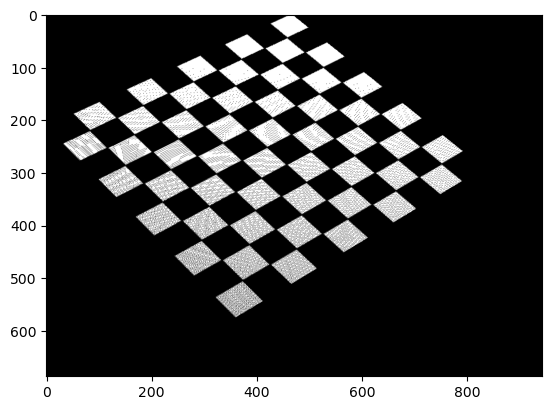

In [10]:
h12h2 = transfer_bilingual(image_h1, H)
plt.imshow(h12h2)

[[-257.41783446  210.42659985  340.70504277  734.07496695]
 [ 154.24431997  808.19675249 -207.60142982  285.42779426]]
[734.0749669516827, -257.41783445606893, 808.1967524890135, -207.60142981972396]


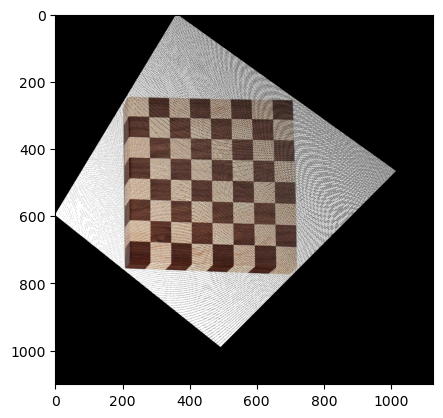

In [13]:
points2 = nodes[4:8] + nodes[0:4]
H2 = homography(points2)
# print(H2)
H_1 = np.linalg.inv(H)
# print(H_1)
h22h1 = transfer_bilingual(image_h2, H2)
plt.imshow(h22h1)

In [14]:
loc = Tk()
nodes_n = []

loc.geometry("1000x1000")
loc.title("part3")
canvas = Canvas(loc, bg='white', width=1080, height=1200)
canvas.pack()

img_bus = Image.open('./img/bus.jpg')
img_bus_photo = ImageTk.PhotoImage(img_bus)
img_canvas = canvas.create_image(0, 0, image=img_bus_photo, anchor=NW)
canvas.config(scrollregion=canvas.bbox(ALL))

text_canvas = canvas.create_text(200, 730, text="Click Order: top left, top right, down left, down right",
                                 font=("Arial", 15))
canvas.create_text(180, 750, text="Position of points:", font=("Arial", 15))


def print_pos_1(e):
    cx, cy = e2c(e, canvas)
    click = [e.y, e.x, cy, cx]
    print("(%d, %d) / (%d, %d)" % (e.y, e.x, cy, cx))
    nodes_n.append(click)
    i = len(nodes_n)
    canvas.create_text(300 + i * 50, 750, text="(%d,%d)" % (e.y, e.x), font=("Arial", 10))


canvas.bind("<ButtonPress-1>", print_pos_1)

loc.mainloop()

(214, 583) / (211, 583)
(233, 794) / (230, 794)
(516, 598) / (513, 598)
(470, 802) / (467, 802)


In [15]:
bus = cv.imread('./img/bus.jpg', cv.IMREAD_COLOR)
simpsons = cv.imread('./img/simpsons.jpg', cv.IMREAD_COLOR)
bus = cv.cvtColor(bus, cv.COLOR_BGR2RGB)
simpsons = cv.cvtColor(simpsons, cv.COLOR_BGR2RGB)

# plt.imshow(simpsons)

In [16]:
[row, col, c] = simpsons.shape
print(col, row)
# lt = [[0, 0, 0, 0]]
# rt = [[0, col - 1, 0, col - 1]]
# lb = [[row - 1, 0, row - 1, 0]]
# rb = [[row - 1, col - 1, row - 1, col - 1]]
# top left, top right, down left, down right
lt = [[0, 0, 0, 0]]
rt = [[0, col, 0, col]]
lb = [[row, 0, row, 0]]
rb = [[row, col, row, col]]
points_add = lt + rt + lb + rb + nodes_n

H3 = homography(points_add)
Simpsons_trans = transfer_bilingual(simpsons, H3)
# plt.imshow(Simpsons_trans)


1000 1500
[[211.         229.99999999 513.         467.00000001]
 [582.99999997 793.99999998 598.00000002 802.00000002]]
[513.0000000040774, 211.0, 802.0000000231194, 582.9999999657836]


In [17]:
def add_Simpsons(x_min, x_max, Simpsons, bus_add):
    # add Simpsons to bus
    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            x = i - x_min
            y = j - y_min
            if any(Simpsons[x, y] > 0):
                # print(Simpsons[x, y])
                bus_add[i, j] = Simpsons[x, y][:]

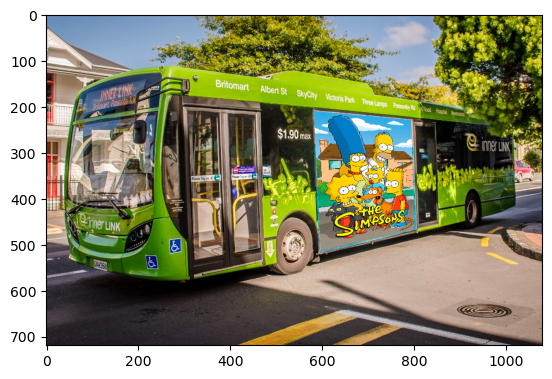

In [18]:
bus_add = cv.imread('./img/bus.jpg', cv.IMREAD_COLOR)
bus_add = cv.cvtColor(bus_add, cv.COLOR_BGR2RGB)

points_2 = np.array(nodes_n)
x_max = int(np.max(points_2[:, 2]))
y_max = int(np.max(points_2[:, 3]))
x_min = int(np.min(points_2[:, 2]))
y_min = int(np.min(points_2[:, 3]))
add_Simpsons(x_min, x_max, Simpsons_trans, bus_add)
plt.imshow(bus_add)
# print(x_min, x_max, y_min, y_max)
